In [3]:
import pandas as pd

import polars as pl
import re
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from datetime import date, datetime
from datetime import timedelta

from tslearn.clustering import TimeSeriesKMeans 
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

logging.getLogger('matplotlib.font_manager').disabled = True



In [4]:
key_path = "/Users/jansigrist/Documents/SP/Customer-_Segmentation_CKW/DATA/Survey_Data/00_SWW_ID_smartmeter.xlsx"
key_df = pd.read_excel(key_path, header=None)

# Load the Excel file
file_path = "/Users/jansigrist/Documents/SP/Customer-_Segmentation_CKW/DATA/Survey_Data/Survey_Data.xlsx"
# Read without headers, so columns are numbered 0,1,2,...
df = pd.read_excel(file_path, skiprows=4, nrows=1500, header=None)

# Now columns 10 and 16 correspond to Excel columns K and Q exactly (0-based)
cols_to_extract = [10, 16]
extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['house-id', 'heating type']

#print(extracted_df)

# Save extracted columns to a new Excel or CSV file if needed

#extracted_df.to_csv("extracted_columns.csv", index=False)

In [5]:

# Column 1 (index 0) has original house IDs, column 2 (index 1) has CH... identifiers
# Create a mapping dict: {house_id: CH_id}
mapping = dict(zip(key_df.iloc[:,0], key_df.iloc[:,2]))

# Map 'house-id' in extracted_df to 'CH...' values
# Safely assign new column using .loc to avoid SettingWithCopyWarning
extracted_df.loc[:, 'CH_id'] = extracted_df['house-id'].map(mapping)

print(extracted_df.head())


   house-id   heating type                              CH_id
0     10015  I do not know  CH1018601234500000000000000106795
1     10030  I do not know  CH1018601234500000000000000106801
2     10135  I do not know  CH1018601234500000000000000106840
3     10207    Electricity  CH1018601234500000000000000107070
4     10219      Heat Pump  CH1018601234500000000000000107076


/var/folders/db/p0yj0j2s77j2q7kn7qv0ns640000gn/T/ipykernel_76703/1723262949.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_df.loc[:, 'CH_id'] = extracted_df['house-id'].map(mapping)


In [6]:
pattern = f"{r'DATA/SM_DATA_average_min'}/*CH*.csv"
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

Shape of the 3D array: (1464, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


In [7]:
train_data = data_3d

n_clusters = 7  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

0.300 --> 0.185 --> 0.179 --> 0.176 --> 0.175 --> 0.174 --> 0.174 --> 0.173 --> 0.173 --> 0.172 --> 0.171 --> 0.171 --> 0.170 --> 0.170 --> 0.170 --> 0.170 --> 0.170 --> 


In [8]:
# Initialize an empty list to store individual DataFrames for each cluster
cluster_dataframes = []

for cluster_idx in range(n_clusters):
    # Get all indices in this cluster
    cluster_indices = np.where(clusters_train == cluster_idx)[0]
    
    # Create a Polars DataFrame for the current cluster's indices
    cluster_df = pl.DataFrame({
        "cluster": pl.Series([cluster_idx + 1] * len(cluster_indices)),
        "index": pl.Series(cluster_indices)
    })
    
    # Append this cluster DataFrame to the list
    cluster_dataframes.append(cluster_df)

# Concatenate all cluster DataFrames into one
cluster_indices_df = pl.concat(cluster_dataframes)

# Print the DataFrame to verify
print("\nCluster Indices DataFrame:")
print(cluster_indices_df.head())


Cluster Indices DataFrame:
shape: (5, 2)
┌─────────┬───────┐
│ cluster ┆ index │
│ ---     ┆ ---   │
│ i64     ┆ i64   │
╞═════════╪═══════╡
│ 1       ┆ 1     │
│ 1       ┆ 2     │
│ 1       ┆ 4     │
│ 1       ┆ 5     │
│ 1       ┆ 6     │
└─────────┴───────┘


In [9]:
# Convert filename_list items to strings if not already
house_ids = [str(h) for h in filename_list]

# Create Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1  # adjust if needed
})

extracted_pl_df = pl.from_pandas(extracted_df)

# Assume extracted_pl_df has a column named 'CH_id' that matches result_df['house_id']
# Normalize keys in both DataFrames for clean join
extracted_pl_df = extracted_pl_df.with_columns(
    pl.col("CH_id").cast(pl.Utf8).str.strip_chars().str.to_lowercase().alias("ch_id_clean")
)

result_df = result_df.with_columns(
    pl.col("house_id").cast(pl.Utf8).str.strip_chars().str.to_lowercase().alias("ch_id_clean")
)

# Join on the cleaned CH_id keys, selecting heating type
final_df = result_df.join(
    extracted_pl_df.select(["ch_id_clean", "heating type"]),
    left_on="ch_id_clean",
    right_on="ch_id_clean",
    how="left"
).select([
    "house_id",      # Original CH id from result_df
    "cluster",
    "heating type"
])

print("Final joined DataFrame with heating type:")
print(final_df.head())

Final joined DataFrame with heating type:
shape: (5, 3)
┌─────────────────────────────────┬─────────┬────────────────────────┐
│ house_id                        ┆ cluster ┆ heating type           │
│ ---                             ┆ ---     ┆ ---                    │
│ str                             ┆ i64     ┆ str                    │
╞═════════════════════════════════╪═════════╪════════════════════════╡
│ CH1018601234500000000000000040… ┆ 7       ┆ Other (please specify) │
│ CH1018601234500000000000000047… ┆ 1       ┆ Pellets                │
│ CH1018601234500000000000000112… ┆ 1       ┆ Other (please specify) │
│ CH1018601234500000000000000112… ┆ 1       ┆ Other (please specify) │
│ CH1018601234500000000000000076… ┆ 7       ┆ Heat Pump              │
└─────────────────────────────────┴─────────┴────────────────────────┘


In [10]:
# Unique clusters and heating types

final_df = final_df.to_pandas()
final_df['heating type'] = final_df['heating type'].astype(str)

clusters = sorted(final_df['cluster'].unique())
heating_types = final_df['heating type'].unique()

counts = {ht: [] for ht in heating_types}

for cl in clusters:
    cluster_subset = final_df[final_df['cluster'] == cl]
    for ht in heating_types:
        count_ht = sum(cluster_subset['heating type'] == ht)
        counts[ht].append(count_ht)

# Now, each counts[ht] list should have length == len(clusters)

# Build DataFrame for plotting



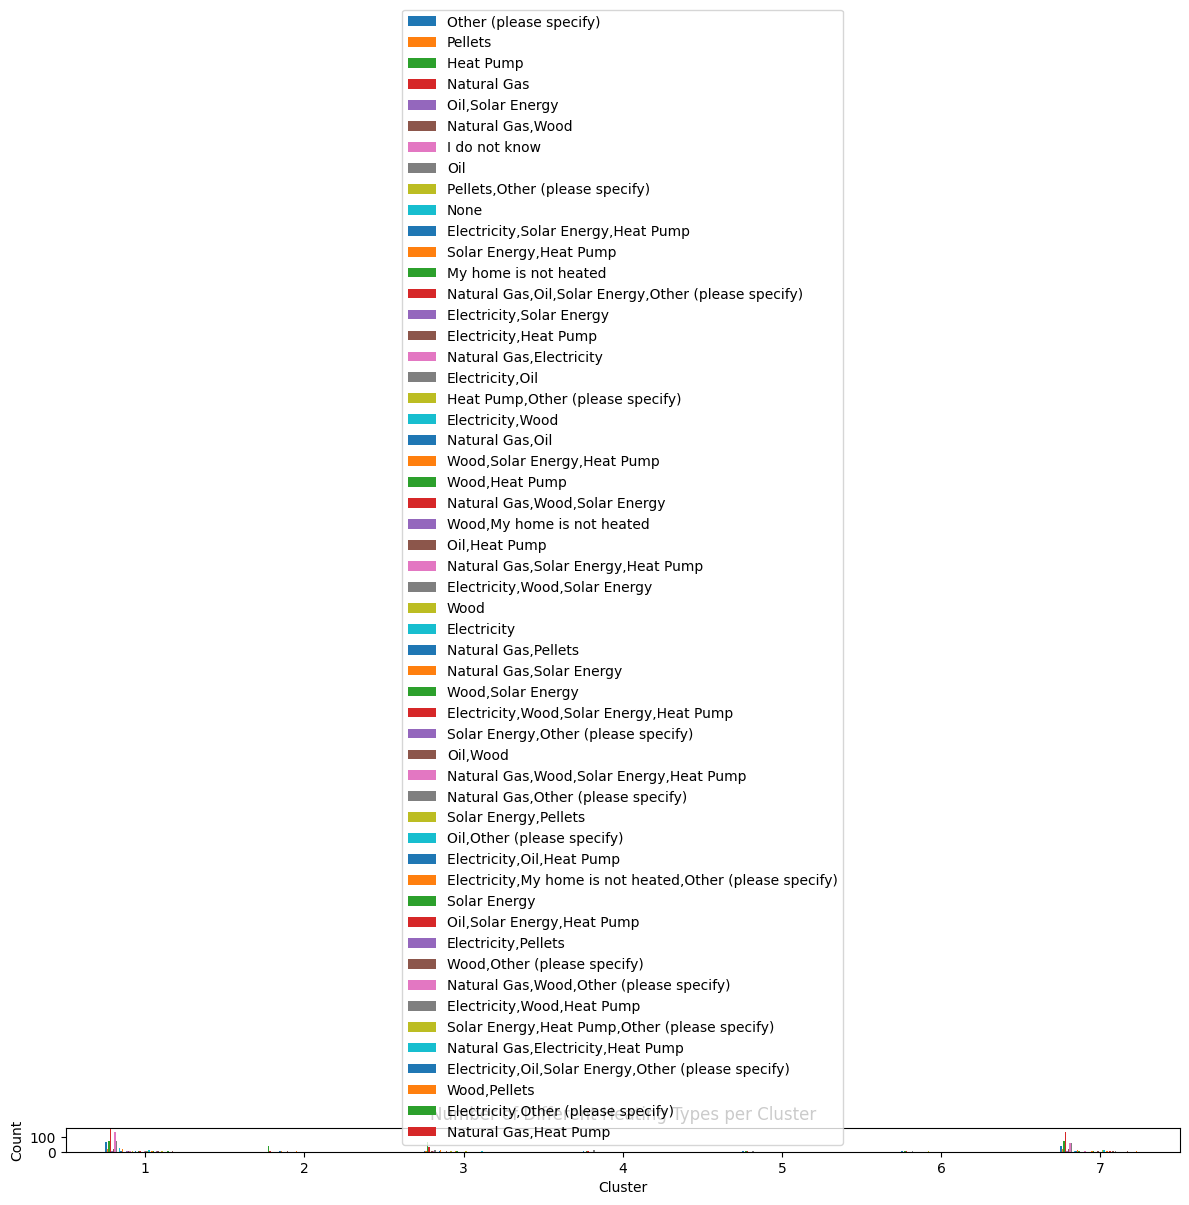

In [11]:

count_df = pd.DataFrame(counts, index=clusters)

count_df.plot(kind='bar', stacked=False, figsize=(12, 7))
plt.title("Number of Different Heating Types per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
#plt.legend(title="Heating Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

